In [1]:
pip install yfinance numpy pandas matplotlib scikit-learn keras tensorflow

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import datetime as dt

In [3]:
def create_sequences(data, step_size=60):
    X, y = [], []
    for i in range(step_size, len(data)):
        X.append(data[i - step_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)


In [4]:
# Step 1: Get Stock Data from Yahoo Finance
def fetch_stock_data(stock_ticker, years=5):
    """
    Fetch historical stock data for a given ticker and number of years.

    Parameters:
        stock_ticker (str): The stock ticker symbol (e.g., AAPL, TSLA).
        years (int): Number of years of historical data to fetch.

    Returns:
        pandas.DataFrame: Stock price data.
    """
    end_date = dt.datetime.now()
    start_date = end_date - dt.timedelta(days=years * 365)  # Fetch `years` of data
    data = yf.download(stock_ticker, start=start_date, end=end_date)
    if data.empty:
        raise ValueError("Invalid stock ticker or no data available.")
    return data


In [5]:
def preprocess_data(data, step_size=30):  # Adjusted step size
    """
    Preprocess stock data for LSTM model.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    print("Scaled data shape:", scaled_data.shape)

    # Split data into training (70%) and testing (30%) sets
    train_size = int(len(scaled_data) * 0.7)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    print("Train data shape:", train_data.shape)
    print("Test data shape:", test_data.shape)

    # Ensure enough data for sequence creation
    if len(train_data) < step_size or len(test_data) < step_size:
        raise ValueError("Not enough data for sequence creation. Adjust step size or data split.")

    # Create sequences
    X_train, y_train = create_sequences(train_data, step_size=step_size)
    X_test, y_test = create_sequences(test_data, step_size=step_size)

    # Reshape data for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    print("Final X_train shape:", X_train.shape)
    print("Final X_test shape:", X_test.shape)

    return scaler, X_train, y_train, X_test, y_test


In [6]:
# Step 3: Build the LSTM Model
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [7]:
# Step 4: Predict for Next 5 Days
def predict_next_5_days(model, scaled_data, scaler):
    last_sequence = scaled_data[-60:]
    next_5_days = []
    for _ in range(5):
        prediction = model.predict(last_sequence.reshape(1, -1, 1))
        next_5_days.append(prediction[0, 0])
        last_sequence = np.append(last_sequence[1:], prediction[0, 0]).reshape(-1, 1)

    return scaler.inverse_transform(np.array(next_5_days).reshape(-1, 1))

Enter the stock ticker symbol (e.g., AAPL, TSLA, AMZN): aapl
Enter the number of years of historical data to fetch (e.g., 2, 5): 2
Fetching 2 years of data for: AAPL
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fetched data:
 Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2023-05-01  167.896805  168.748219  166.956293  167.589902   52472900
2023-05-02  166.857285  168.649226  165.867269  168.391812   48425700
2023-05-03  165.778168  169.213524  165.491070  167.807703   65136000
2023-05-04  164.134735  165.372255  162.669516  163.243727   81235400
2023-05-05  171.837067  172.559774  169.055109  169.272914  113316400
Preprocessing data...
Scaled data shape: (500, 1)
Train data shape: (350, 1)
Test data shape: (150, 1)
Final X_train shape: (320, 30, 1)
Final X_test shape: (120, 30, 1)
Train data shapes: X_train=(320, 30, 1), y_train=(320,)
Test data shapes: X_test=(120, 30, 1), y_test=(120,)
Building and training the model...
Epoch 1/45
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0649
Epoch 2/45
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms

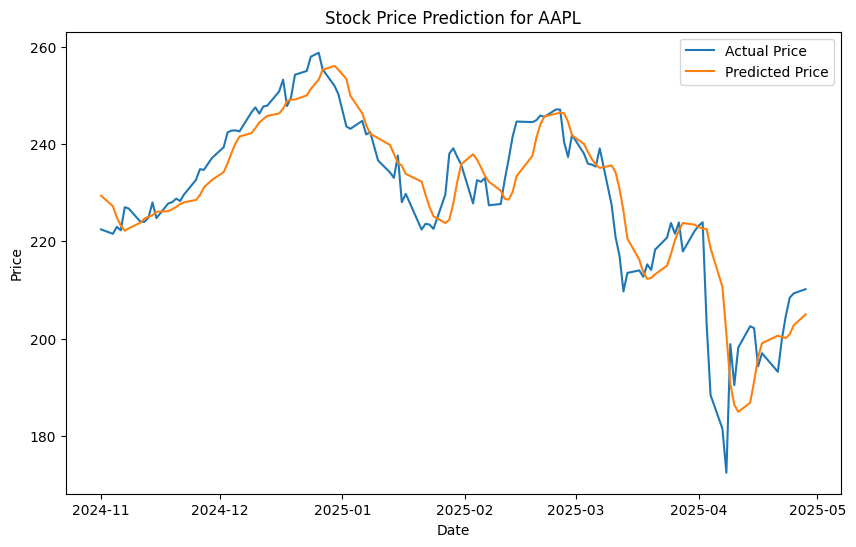

Predicting prices for the next 5 days...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted Prices for Next 5 Days: [207.2006  208.4073  208.98795 209.18027 209.14554]


In [8]:
if __name__ == "__main__":
    stock_ticker = input("Enter the stock ticker symbol (e.g., AAPL, TSLA, AMZN): ").strip().upper()
    years = int(input("Enter the number of years of historical data to fetch (e.g., 2, 5): ").strip())

    try:
        print(f"Fetching {years} years of data for:", stock_ticker)
        data = fetch_stock_data(stock_ticker, years=years)
        print("Fetched data:\n", data.head())

        if len(data) < 60:
            raise ValueError("Not enough data to train the model. Please try another stock or reduce sequence length.")

        print("Preprocessing data...")
        scaler, X_train, y_train, X_test, y_test = preprocess_data(data)
        print(f"Train data shapes: X_train={X_train.shape}, y_train={y_train.shape}")
        print(f"Test data shapes: X_test={X_test.shape}, y_test={y_test.shape}")

        print("Building and training the model...")
        model = build_model((X_train.shape[1], 1))
        model.fit(X_train, y_train, epochs=45, batch_size=32, verbose=1)

        print("Making predictions...")
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(predictions)

        # Visualize predictions
        plt.figure(figsize=(10, 6))
        plt.plot(data.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1, 1)), label='Actual Price')
        plt.plot(data.index[-len(predictions):], predictions, label='Predicted Price')
        plt.title(f'Stock Price Prediction for {stock_ticker}')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

        # Predict next 5 days
        print("Predicting prices for the next 5 days...")
        next_5_days = predict_next_5_days(model, scaler.transform(data['Close'].values.reshape(-1, 1)), scaler)
        print("Predicted Prices for Next 5 Days:", next_5_days.flatten())
    except Exception as e:
        print("Error:", e)


In [9]:
# After making predictions for the test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Convert to actual values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))  # Convert test labels to actual values

# Calculate accuracy for test data predictions
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100
test_accuracy = 100 - mape

print(f"Test Data Prediction Accuracy: {test_accuracy:.2f}%")

# After predicting next 5 days
print("Predicted Prices for Next 5 Days:", next_5_days.flatten())

# If actual future prices are available, calculate accuracy
# Replace 'actual_next_5_days' with the true values for the next 5 days
# actual_next_5_days = np.array([240, 241, 242, 243, 244]).reshape(-1, 1)  # Example true values
# mape_next_5 = np.mean(np.abs((actual_next_5_days - next_5_days) / actual_next_5_days)) * 100
# next_5_accuracy = 100 - mape_next_5
# print(f"Next 5-Day Prediction Accuracy: {next_5_accuracy:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test Data Prediction Accuracy: 97.61%
Predicted Prices for Next 5 Days: [207.2006  208.4073  208.98795 209.18027 209.14554]
